This script is used to do some analysis using RGC data in the paper (Baden, 2016, Nature).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import cv2
import glob
import h5py
from skimage.morphology import disk
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
import scipy.io
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# for plot figures
plt.rcParams['svg.fonttype'] = 'none'
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])

In [4]:
#load data
data_name = "data/BadenEtAl_RGCs_2016_v1.mat"
rgcdata=scipy.io.loadmat(data_name)
print (rgcdata.keys())

dict_keys(['bar_qi', '__version__', 'cell_oo_idx', 'cell_op', 'noise_trace', 'chirp_avg', 'noise_time', 'c2g', 'sel_idx', 'ans', '__globals__', 'cell_area', 'offsets', 'color_byrepeat', 'rf_size', 'genetics_pv', 'chirp_byrepeat', 'immuno_smi', 'bar_byrepeat', 'bar_tc', 'noise_stim', 'cell_dp', 'color_avg', 'rois', 'rf_qi', 'immuno_melanopsin', 'cell_ff_idx', 'rf_gauss_mean', 'cell_volume', 'cell_id', 'structural', 'color_time', 'group_idx', '__header__', 'cell_osi', 'color_qi', 'genetics_pcp', 'rf_tc', 'chirp_scaling', 'chirp_time', 'cluster_idx', 'chirp_stim', 'bar_time', 'immuno_gad', 'rf_time', 'immuno_chat', 'rf_gauss_std', 'chirp_qi', 'cell_dsi', 'chirp_stim_time', 'rf_map'])


### Analysis

group index 1-9 and 31 and 32: OFF

group index 15-30: ON

rf_qi>0.2, rf_size>50 and <450

then use the corresponding onoff index

In [5]:
group_idx=rgcdata['group_idx'].flatten()#group number
rf_qi=rgcdata['rf_qi'].flatten()
rf_size=rgcdata['rf_size'].flatten()#RF diamter (2 sd of gaussian)
cell_oo_idx=rgcdata['cell_oo_idx'].flatten()#onoff index
print ('shape of group_idx:{}'.format(group_idx.shape))
print ('shape of rf_qi:{}'.format(rf_qi.shape))
print ('shape of rf_size:{}'.format(rf_size.shape))
print ('shape of cell_oo_idx:{}'.format(cell_oo_idx.shape))

shape of group_idx:(11210,)
shape of rf_qi:(11210,)
shape of rf_size:(11210,)
shape of cell_oo_idx:(11210,)


In [6]:
oncells_group_idx=[]
oncells_size=[]
offcells_group_idx=[]
offcells_size=[]
onoffcells=[]#on:1, off:-1 and RF size
onoffcells_group=[]#group index and RF size
onoffcells_ooi=[]#onoff index and RF size for all cells
oncells_ooi   =[]#onoff index and RF size for ON cells
offcells_ooi  =[]#onoff index and RF size for OFF cells

on_group_idx=np.arange(15,31)
on_group_idx=list(on_group_idx)
off_group_idx=np.arange(1,10)
off_group_idx=list(off_group_idx)
off_group_idx.append(31)
off_group_idx.append(32)

for ii in range(len(rf_size)):
    if rf_size[ii]<450 and rf_size[ii]>50 and rf_qi[ii]>0.2:
        if group_idx[ii] in on_group_idx:
            oncells_group_idx.append(group_idx[ii])
            oncells_size.append(rf_size[ii])
            onoffcells.append(np.array([1,rf_size[ii]]))
            onoffcells_group.append(np.array([group_idx[ii],rf_size[ii]]))
            onoffcells_ooi.append(np.array([cell_oo_idx[ii],rf_size[ii]]))
            oncells_ooi.append(np.array([cell_oo_idx[ii],rf_size[ii]]))
        if group_idx[ii] in off_group_idx:
            offcells_group_idx.append(group_idx[ii])
            offcells_size.append(rf_size[ii])
            onoffcells.append(np.array([-1,rf_size[ii]]))
            onoffcells_group.append(np.array([group_idx[ii],rf_size[ii]]))
            onoffcells_ooi.append(np.array([cell_oo_idx[ii],rf_size[ii]]))
            offcells_ooi.append(np.array([cell_oo_idx[ii],rf_size[ii]]))

onoffcells=np.array(onoffcells)
onoffcells_group=np.array(onoffcells_group)
oncells_size=np.array(oncells_size)
offcells_size=np.array(offcells_size)
onoffcells_ooi=np.array(onoffcells_ooi)
oncells_ooi   =np.array(oncells_ooi)
offcells_ooi  =np.array(offcells_ooi)

print ('shape of onoffcells:{}'.format(onoffcells.shape))
print ('shape of onoffcells:{}'.format(onoffcells.shape))
print ('shape of oncells_size:{}'.format(oncells_size.shape))
print ('shape of offcells_size:{}'.format(offcells_size.shape))
print ('shape of onoffcells_ooi:{}'.format(onoffcells_ooi.shape))

shape of onoffcells:(2380, 2)
shape of onoffcells:(2380, 2)
shape of oncells_size:(1036,)
shape of offcells_size:(1344,)
shape of onoffcells_ooi:(2380, 2)


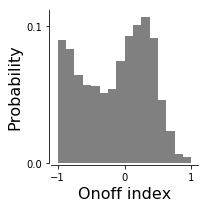

In [7]:
#plot onoff index histogram
xmax=1.0
xmin=-1.0
log_flag=False 
weights = np.ones_like(onoffcells_ooi[:,0])/float(len(onoffcells_ooi[:,0]))

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
axes.hist(onoffcells_ooi[:,0], bins=16,color='gray',range=[xmin,xmax],\
               weights=weights,log=log_flag)
axes.set_yticks([0,0.1])
axes.set_xlabel('Onoff index', fontsize=16)
axes.set_ylabel('Probability', fontsize=16)
adjust_spines(axes, ['left', 'bottom'])
plt.tight_layout()

1036


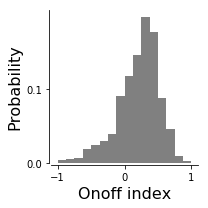

In [8]:
#plot onoff index histogram for on cells
xmax=1.0
xmin=-1.0
log_flag=False #log scale histogram if it is True
weights = np.ones_like(oncells_ooi[:,0])/float(len(oncells_ooi[:,0]))
print (len(oncells_ooi))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
axes.hist(oncells_ooi[:,0], bins=16,color='gray',range=[xmin,xmax],\
               weights=weights,log=log_flag)
axes.set_yticks([0,0.1])
axes.set_xlabel('Onoff index', fontsize=16)
axes.set_ylabel('Probability', fontsize=16)
adjust_spines(axes, ['left', 'bottom'])
plt.tight_layout()

1344


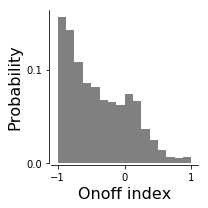

In [9]:
#plot onoff index histogram for off cells
xmax=1.0
xmin=-1.0
log_flag=False #log scale histogram if it is True
weights = np.ones_like(offcells_ooi[:,0])/float(len(offcells_ooi[:,0]))
print (len(offcells_ooi))
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
axes.hist(offcells_ooi[:,0], bins=16,color='gray',range=[xmin,xmax],\
               weights=weights,log=log_flag)
axes.set_yticks([0,0.1])
axes.set_xlabel('Onoff index', fontsize=16)
axes.set_ylabel('Probability', fontsize=16)
adjust_spines(axes, ['left', 'bottom'])
plt.tight_layout()

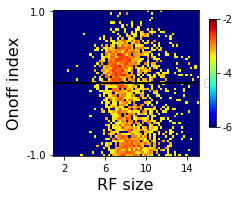

In [11]:
#plot 2d histogram of onoff index and rf size
xmax=450
xmin=30 
ymax=1.0
ymin=-1.0
weights = np.ones_like(onoffcells_ooi[:,1])/float(len(onoffcells_ooi[:,1]))
rfsize_ooidx=np.zeros((64,64))

rfsize_ooidx,_,_=np.histogram2d(onoffcells_ooi[:,1], \
                                onoffcells_ooi[:,0], \
                                bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
rfsize_ooidx=np.log10(rfsize_ooidx+1e-6)
rfsize_ooidx=rfsize_ooidx.T
H_max=-2 
H_min=-6 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
im=axes.imshow(rfsize_ooidx, interpolation='nearest', origin='low',cmap='jet',vmin=H_min, vmax=H_max)
labels = ['2','6','10','14']
axes.set_xticks([4.5,22.5,40.5,58.5]) # 0: 30um, 63:450um, 
axes.set_xticklabels(labels)
labels = [float("{0:.1f}".format(ymin)),float("{0:.1f}".format(ymax))]
axes.set_yticks([0,63])
axes.set_yticklabels(labels)
axes.axhline(y=31.5,color='k',linewidth=2)
axes.set_xlabel('RF size', fontsize=16)
axes.set_ylabel('Onoff index', fontsize=16)
#
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

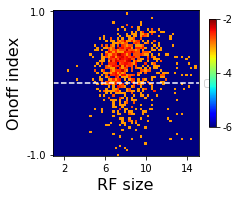

In [12]:
#plot 2d histogram of onoff index and rf size, ON cells
xmax=450
xmin=30 # 50
ymax=1.0
ymin=-1.0

weights = np.ones_like(oncells_ooi[:,1])/float(len(oncells_ooi[:,1]))
rfsize_ooidx=np.zeros((64,64))

rfsize_ooidx,_,_=np.histogram2d(oncells_ooi[:,1], \
                                oncells_ooi[:,0], \
                                bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
rfsize_ooidx=np.log10(rfsize_ooidx+1e-6)
rfsize_ooidx=rfsize_ooidx.T
H_max=-2 
H_min=-6 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
im=axes.imshow(rfsize_ooidx, interpolation='nearest', origin='low',cmap='jet',vmin=H_min, vmax=H_max)
labels = ['2','6','10','14']
axes.set_xticks([4.5,22.5,40.5,58.5]) 
axes.set_xticklabels(labels)
labels = [float("{0:.1f}".format(ymin)),float("{0:.1f}".format(ymax))]
axes.set_yticks([0,63])
axes.set_yticklabels(labels)
axes.axhline(y=31.5,color='white',linestyle='--')
axes.set_xlabel('RF size', fontsize=16)
axes.set_ylabel('Onoff index', fontsize=16)
#
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

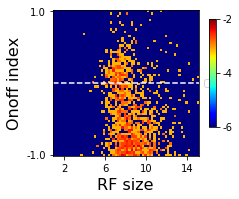

In [13]:
#plot 2d histogram of onoff index and rf size, OFF cells
xmax=450
xmin=30 
ymax=1.0
ymin=-1.0
weights = np.ones_like(offcells_ooi[:,1])/float(len(offcells_ooi[:,1]))
rfsize_ooidx=np.zeros((64,64))

rfsize_ooidx,_,_=np.histogram2d(offcells_ooi[:,1], \
                                offcells_ooi[:,0], \
                                bins=64,range=[[xmin,xmax],[ymin,ymax]],weights=weights)
rfsize_ooidx=np.log10(rfsize_ooidx+1e-6)
rfsize_ooidx=rfsize_ooidx.T
H_max=-2 
H_min=-6 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
im=axes.imshow(rfsize_ooidx, interpolation='nearest', origin='low',cmap='jet',vmin=H_min, vmax=H_max)
labels = ['2','6','10','14']
axes.set_xticks([4.5,22.5,40.5,58.5]) 
axes.set_xticklabels(labels)
labels = [float("{0:.1f}".format(ymin)),float("{0:.1f}".format(ymax))]
axes.set_yticks([0,63])
axes.set_yticklabels(labels)
axes.axhline(y=31.5,color='white',linestyle='--')
axes.set_xlabel('RF size', fontsize=16)
axes.set_ylabel('Onoff index', fontsize=16)
#
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
ticks=[-2,-4,-6]
fig.colorbar(im, cax=cbar_ax,ticks=ticks,format="%d")
handles, labels = axes.get_legend_handles_labels()
lgd = axes.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

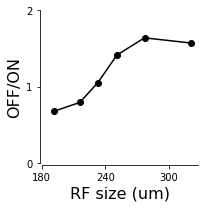

In [14]:
#plot OFF/ON as RF size
#sort cells as RF size
temp=np.argsort(onoffcells_ooi[:,1])
onoffcells_ooi_sorted=onoffcells_ooi[temp][:2376]
onoffcells_sorted    =onoffcells[temp][:2376]#on:1, off:-1 and RF size
num=6
delta=int(len(onoffcells_ooi_sorted)/num)
OFFtoONs=np.zeros(num)
rfsizegroups=np.zeros(num,np.int32)
for ii in range(num):
    temp1=onoffcells_ooi_sorted[ii*delta:ii*delta+delta,0]#onoff index
    temp2=onoffcells_ooi_sorted[ii*delta:ii*delta+delta,1]#rf size
    OFFtoONs[ii]=len(np.where(temp1<0)[0])/len(np.where(temp1>0)[0])
    rfsizegroups[ii]=int(np.median(temp2))
#
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.plot(rfsizegroups,OFFtoONs,'o',color='k',linestyle='-')
ax.set_xticks([6*30,8*30,10*30])
ax.set_yticks([0,1,2])
ax.set_xlabel('RF size (um)', fontsize=16)
ax.set_ylabel('OFF/ON', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
plt.tight_layout()

In [15]:
#boxplot of onoff index, also for bootstrapping and statistical test
Onoff_boxplot=[] #OOi index
Onoff_polarity_boxplot=[] #polarity
for ii in range(num):
    Onoff_boxplot.append(onoffcells_ooi_sorted[ii*delta:ii*delta+delta,0])
    Onoff_polarity_boxplot.append(onoffcells_sorted[ii*delta:ii*delta+delta,0])
Onoff_boxplot_array=np.array(Onoff_boxplot) #OOi index
Onoff_polarity_boxplot_array=np.array(Onoff_polarity_boxplot) #polarity, on:1, off:-1
print (Onoff_boxplot_array.shape)
print (Onoff_polarity_boxplot_array.shape)

(6, 396)
(6, 396)


In [16]:
#bootstrapping
#apply bootstrapping to estimate standard deviation (error)
#statistics can be offratios, median, mean
#for offratios, be careful with the threshold
#data: for statistics offratios, median, mean: numpy array with shape (sample_size,1)
#num_exp: number of experiments, with replacement
def bootstrap(statistics,data,num_exp=10000,seed=66):
    if   statistics == 'offratios':
        def func(x): return len(x[np.where(x<0)])/len(x[np.where(x>0)]) #threshold is 0, may be different
    elif statistics == 'median':
        def func(x): return np.median(x)
    elif statistics == 'mean':
        def func(x): return np.mean(x)
    sta_boot=np.zeros((num_exp))
    num_data=len(data)
    for ii in range(num_exp):
        np.random.seed(seed+ii)
        tempind=np.random.choice(num_data,num_data,replace=True)
        sta_boot[ii]=func(data[tempind])
    return np.percentile(sta_boot,2.5),np.percentile(sta_boot,97.5)

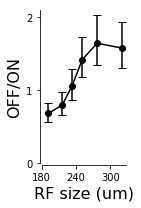

In [17]:
#plot OFF/ON as RF size with bootstrapping
OFFtoONlowqs=np.zeros(len(Onoff_boxplot_array)) #lower_quartile
OFFtoONhigqs=np.zeros(len(Onoff_boxplot_array)) #upper_quartile
for ii in range(len(OFFtoONlowqs)):
    temp=Onoff_boxplot_array[ii]
    tempmax=0 
    low_perc,high_perc=bootstrap('offratios',temp,num_exp=10000,seed=66)
    OFFtoONlowqs[ii]  = OFFtoONs[ii]-low_perc
    OFFtoONhigqs[ii]  =-OFFtoONs[ii]+high_perc 
#
#plot
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,3))
ax.errorbar(rfsizegroups,OFFtoONs,yerr=(OFFtoONlowqs,OFFtoONhigqs),marker='o',color='k',linestyle='-',capsize=4)
ax.set_xticks([6*30,8*30,10*30])
ax.set_yticks([0,1,2])
ax.set_xlabel('RF size (um)', fontsize=16)
ax.set_ylabel('OFF/ON', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
plt.tight_layout()

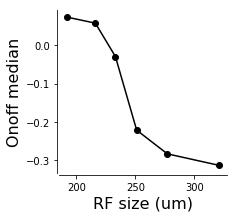

In [18]:
#get the median of onoff index
Onoffmedians=np.zeros(num)
Onoffmeans=np.zeros(num)
rfsizegroups=np.zeros(num,np.int32)
for ii in range(num):
    temp1=onoffcells_ooi_sorted[ii*delta:ii*delta+delta,0]#onoff index
    temp2=onoffcells_ooi_sorted[ii*delta:ii*delta+delta,1]#rf size
    Onoffmedians[ii]=np.median(temp1)
    Onoffmeans[ii]  =np.mean(temp1)
    rfsizegroups[ii]=int(np.median(temp2))
#
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(3,3))
ax.plot(rfsizegroups,Onoffmedians,'o',color='k',linestyle='-')
ax.set_xlabel('RF size (um)', fontsize=16)
ax.set_ylabel('Onoff median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left', frameon=False,bbox_to_anchor=(1, 0.5))

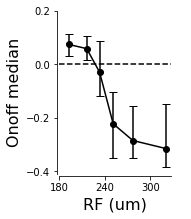

In [19]:
#plot median of onoff index with bootstrapping
Onofflowqs=np.zeros(len(Onoff_boxplot_array)) #lower_quartile
Onoffhigqs=np.zeros(len(Onoff_boxplot_array)) #upper_quartile
for ii in range(len(Onofflowqs)):
    temp=Onoff_boxplot_array[ii]
    low_perc,high_perc=bootstrap('median',temp,num_exp=10000,seed=66)
    Onofflowqs[ii]  = Onoffmedians[ii]-low_perc
    Onoffhigqs[ii]  =-Onoffmedians[ii]+high_perc 
#
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,3))
ax.errorbar(rfsizegroups,Onoffmedians,yerr=(Onofflowqs,Onoffhigqs),marker='o',color='k',linestyle='-',capsize=4)
ax.axhline(y=0,color='k',linestyle='--')
ax.set_xticks([6*30,8*30,10*30])
ax.set_yticks([0.2,0,-0.2,-0.4]) 
ax.set_xlabel('RF (um)', fontsize=16)
ax.set_ylabel('Onoff median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

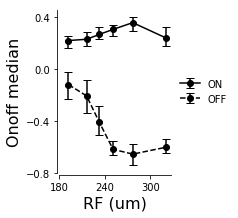

In [20]:
#plot median of onoff index with bootstrapping, ON and OFF separately
#ON
Onofflowqs_ON  =np.zeros(len(Onoff_boxplot_array)) #lower_quartile
Onoffhigqs_ON  =np.zeros(len(Onoff_boxplot_array)) #upper_quartile
Onoffmedians_ON=np.zeros(len(Onoff_boxplot_array))
for ii in range(len(Onofflowqs_ON)):
    temp=Onoff_boxplot_array[ii]
    temp=temp[np.where(Onoff_polarity_boxplot_array[ii]>0)] # ON
    Onoffmedians_ON[ii]=np.median(temp)
    low_perc,high_perc=bootstrap('median',temp,num_exp=10000,seed=66)
    Onofflowqs_ON[ii]  = Onoffmedians_ON[ii]-low_perc
    Onoffhigqs_ON[ii]  =-Onoffmedians_ON[ii]+high_perc 
#OFF
Onofflowqs_OFF  =np.zeros(len(Onoff_boxplot_array)) #lower_quartile
Onoffhigqs_OFF  =np.zeros(len(Onoff_boxplot_array)) #upper_quartile
Onoffmedians_OFF=np.zeros(len(Onoff_boxplot_array))
for ii in range(len(Onofflowqs_OFF)):
    temp=Onoff_boxplot_array[ii]
    temp=temp[np.where(Onoff_polarity_boxplot_array[ii]<0)] # OFF
    Onoffmedians_OFF[ii]=np.median(temp)
    low_perc,high_perc=bootstrap('median',temp,num_exp=10000,seed=66)
    Onofflowqs_OFF[ii]  = Onoffmedians_OFF[ii]-low_perc
    Onoffhigqs_OFF[ii]  =-Onoffmedians_OFF[ii]+high_perc 
#
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(2,3))
ax.errorbar(rfsizegroups,Onoffmedians_ON,yerr=(Onofflowqs_ON,Onoffhigqs_ON),\
            marker='o',color='k',linestyle='-',capsize=4,label='ON')
ax.errorbar(rfsizegroups,Onoffmedians_OFF,yerr=(Onofflowqs_OFF,Onoffhigqs_OFF),\
            marker='o',color='k',linestyle='--',capsize=4,label='OFF')
ax.set_xticks([6*30,8*30,10*30])
ax.set_yticks([-0.8,-0.4,0,0.4])
ax.set_xlabel('RF (um)', fontsize=16)
ax.set_ylabel('Onoff median', fontsize=16)
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))

### Statistical test

#### permutation test

In [27]:
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc

In [42]:
perm_res=[]
for ii in np.arange(len(Onoff_boxplot)):
    for jj in np.arange(ii+1,len(Onoff_boxplot)):
        temp=perm_test(Onoff_boxplot[ii], Onoff_boxplot[jj], 10000, ii*jj+jj+100)
        perm_res.append(temp)
print(perm_res)

[0.0707, 0.0003, 0.0, 0.0, 0.0, 0.0766, 0.0, 0.0, 0.0, 0.0184, 0.0108, 0.0015, 0.8751, 0.4753, 0.5854]
